This scritp aims to solve the Grad-Shafranov equation modelling the plasma equilibrium in an axisymmetrical (cylindrical) system.
It shall constitute the benchmark or miniature code for the actual project behind, which goal is to develop a module for ALYA (BSC-Marenostrum)
computing the plasma equilibrium.

READ INPUT FILES...
     -> READ MESH DATA FILES...Done!
     -> READ EQUILI DATA FILE...Done!
Done!
INITIALIZATION...
     -> INITIALISE LEVEL-SET...Done!
     -> INITIALISE ELEMENTS...Done!
     -> CLASSIFY ELEMENTS...Done!
     -> APPROXIMATE VACUUM VESSEL FIRST WALL...Done!
     -> APPROXIMATE PLASMA/VACUUM INTERFACE...Done!
     -> COMPUTE NUMERICAL INTEGRATION QUADRATURES...Done!
     -> INITIALISE UNKNOWN VECTORS AND COMPUTE INITIAL GUESS...
         -> COMPUTE INITIAL GUESS FOR PSI_NORM...Done!
Total plasma current computed =  -1073737239.5487051
Total plasma current normalization factor =  0.013969898265151486
Normalised total plasma current =  -15000000.0
         -> COMPUTE INITIAL VACUUM VESSEL FIRST WALL VALUES PSI_B...Done!
     Done!
Done!


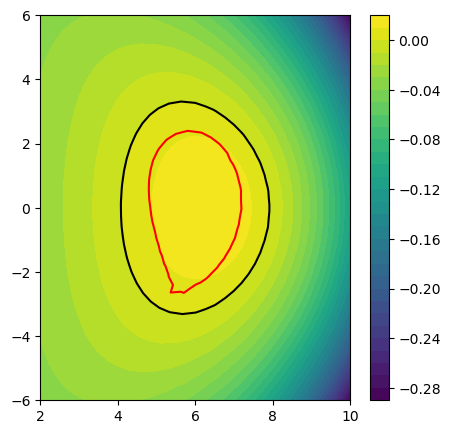

START ITERATION...
OUTER ITERATION = 1 , INNER ITERATION = 1
Total plasma current =  -1073737239.5487051
     Integrate over non-cut elements...Done!
     Integrate over cut-elements subelements...Done!
     Integrate along cut-elements interface edges...Done!
LOCAL EXTREMUM AT  [6.0236982  0.29568531]  (ELEMENT  723 ) WITH VALUE PSI_0 =  [10.49723908]
SADDLE POINT AT  [ 4.09274449 -4.14351203]  (ELEMENT  295 ) WITH VALUE PSI_X =  [-23.36612295]


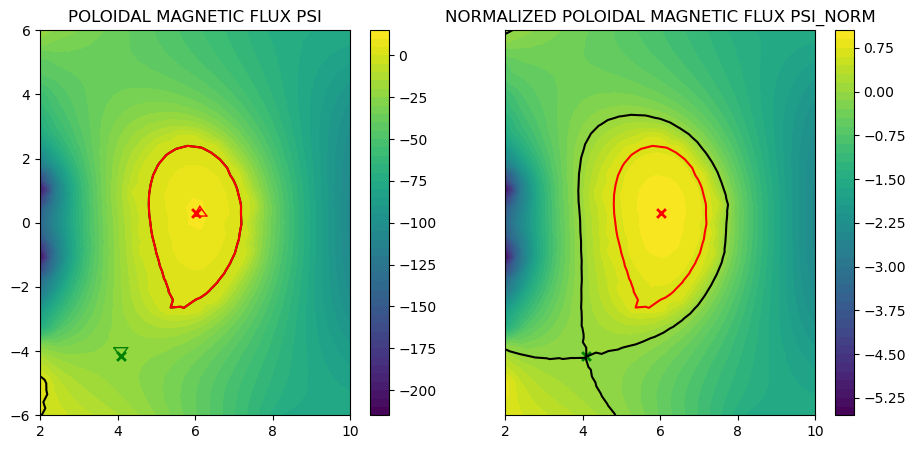

Internal iteration =  1 , PSI_NORM residu =  0.9600239998796681
 
OUTER ITERATION = 1 , INNER ITERATION = 2
Total plasma current =  -78160606590.3398
     Integrate over non-cut elements...Done!
     Integrate over cut-elements subelements...Done!
     Integrate along cut-elements interface edges...Done!
LOCAL EXTREMUM AT  [5.73639184 0.09969289]  (ELEMENT  733 ) WITH VALUE PSI_0 =  [1225.2718871]
SADDLE POINT NOT FOUND. TAKING PREVIOUS SOLUTION
SADDLE POINT AT  [ 4.09274449 -4.14351203]  (ELEMENT  295 ) WITH VALUE PSI_X =  [-23.36612292]


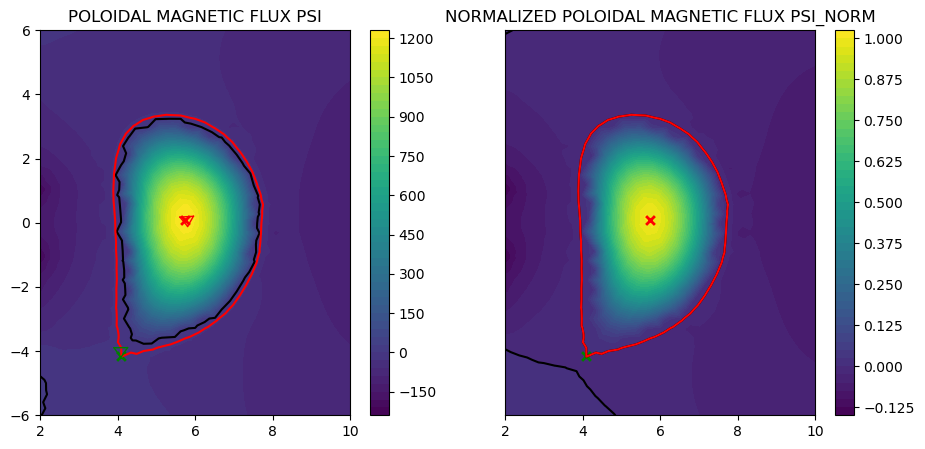

Internal iteration =  2 , PSI_NORM residu =  4.674014434521454
 
OUTER ITERATION = 1 , INNER ITERATION = 3
Total plasma current =  -55428305027.25346
     Integrate over non-cut elements...Done!
     Integrate over cut-elements subelements...Done!
     Integrate along cut-elements interface edges...Done!
LOCAL EXTREMUM AT  [5.66462004 0.05549264]  (ELEMENT  971 ) WITH VALUE PSI_0 =  [1092.40195338]
SADDLE POINT NOT FOUND. TAKING PREVIOUS SOLUTION
SADDLE POINT AT  [ 4.09274449 -4.14351203]  (ELEMENT  295 ) WITH VALUE PSI_X =  [-23.36612289]


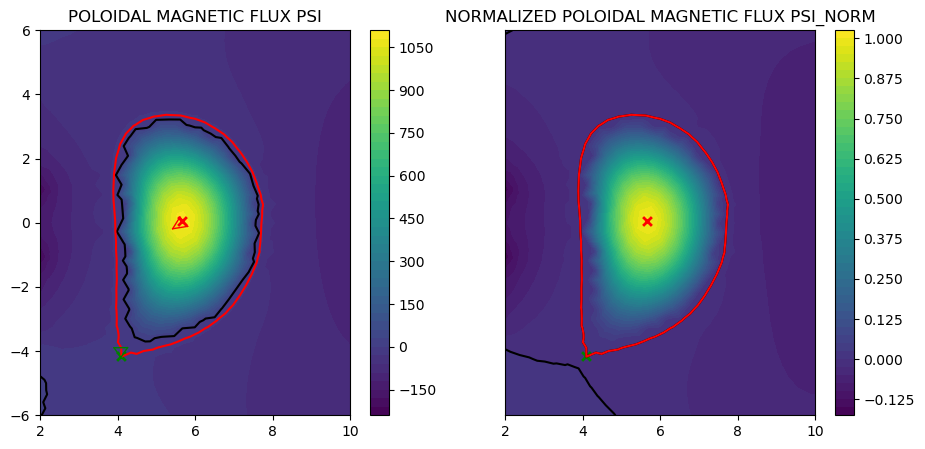

Internal iteration =  3 , PSI_NORM residu =  0.09062716859371092
 
OUTER ITERATION = 1 , INNER ITERATION = 4
Total plasma current =  -50993331613.19277
     Integrate over non-cut elements...Done!
     Integrate over cut-elements subelements...Done!
     Integrate along cut-elements interface edges...Done!


KeyboardInterrupt: 

In [2]:
import sys
sys.path.append('/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/')

from src.GradShafranovCutFEM import *

### LOCATION OF FOLDERS
folder_MESHES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/MESHES/'   # MESHES
folder_CASES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/CASES/'     # CASES

### SELECT MESH FOLDER...
###### LINEAR TRIANGULAR ELEMENT MESH
#MESH = 'TS-CUTFEM-TRI03-COARSE'
MESH = 'TS-CUTFEM-TRI03-MEDIUM'
#MESH = 'TS-CUTFEM-TRI03-FINE'
#MESH = 'TS-CUTFEM-TRI03-SUPERFINE'
#MESH = 'TS-CUTFEM-TRI03-MEGAFINE'
###### QUADRATIC TRIANGULAR ELEMENT MESH
#MESH = 'TS-CUTFEM-TRI06-COARSE'
#MESH = 'TS-CUTFEM-TRI06-MEDIUM'
#MESH = 'TS-CUTFEM-TRI06-FINE'
#MESH = 'TS-CUTFEM-TRI06-SUPERFINE'
#MESH = 'TS-CUTFEM-TRI06-MEGAFINE'
#MESH = 'TS-CUTFEM-TRI06-ULTRAFINE'
###### CUBIC TRIANGULAR ELEMENT MESH
#MESH = 'TS-CUTFEM-TRI10-COARSE'
#MESH = 'TS-CUTFEM-TRI10-MEDIUM'
#MESH = 'TS-CUTFEM-TRI10-FINE'
#MESH = 'TS-CUTFEM-TRI10-SUPERFINE'
#MESH = 'TS-CUTFEM-TRI10-MEGAFINE'

###### LINEAR QUADRILATERAL ELEMENT MESH
#MESH = 'TS-CUTFEM-QUA04-COARSE'
#MESH = 'TS-CUTFEM-QUA04-MEDIUM'
#MESH = 'TS-CUTFEM-QUA04-FINE'
###### QUADRATIC QUADRILATERAL ELEMENT MESH
#MESH = 'TS-CUTFEM-QUA09-COARSE'
#MESH = 'TS-CUTFEM-QUA09-MEDIUM'
#MESH = 'TS-CUTFEM-QUA09-FINE'
###### CUBIC QUADRILATERAL ELEMENT MESH
#MESH = 'TS-CUTFEM-QUA16-FINE'

# ... WITH MESH ELEMENTS:
ElementType = 1     # Element type -> 1: TRIANGLE  ; 2: QUADRILATERAL
ElementOrder = 1    # Element order -> 1: LINEAR  ; 2: QUADRATIC ; 3: CUBIC ...

### SELECT SOLUTION CASE FILE:
#CASE = 'TS-FREE-F4E-LINEAR'          # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND LINEAR PLASMA CURRENT
#CASE = 'TS-FREE-F4E-NONLINEAR'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND NONLINEAR PLASMA CURRENT MODEL
CASE = 'TS-FREE-F4E-PROFILES'        # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY AND PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD
#CASE = 'TS-FREE-F4E-PROFILES_2'        
#CASE = 'TS-FREE-F4E-PROFILES_3'
#CASE = 'TS-FREE-F4E-LINEAR-1W'       # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, LINEAR PLASMA CURRENT AND FIRST WALL VACUUM VESSEL GEOMETRY  
#CASE = 'TS-FREE-F4E-PROFILES-1W'     # FREE PLASMA BOUNDARY WITH F4E PLASMA REGION GEOMETRY, PLASMA CURRENT MODEL BASED ON PROFILES FOR PRESSURE AND TOROIDAL FIELD AND FIRST WALL VACUUM VESSEL GEOMETRY  

##############################################################

# DECLARE OBJECT PROBLEM 
Problem = GradShafranovCutFEM(folder_MESHES+MESH,folder_CASES+CASE,ElementType,ElementOrder)
Problem.EQUILI()